In [190]:
import daft
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import altair as alt

# Problem 1

<Axes: >

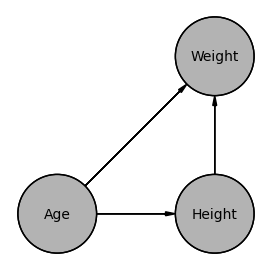

In [191]:
dag = daft.PGM()
dag.add_node("A", "Age", x=0, y=0, observed=True, scale=2)
dag.add_node("H", "Height", x=2, y=0, observed=True, scale=2)
dag.add_node("W", "Weight", x=2,y=2, observed=True, scale=2)
dag.add_edge("A", "W")
dag.add_edge("A", "H")
dag.add_edge("H", "W")
dag.render()

## Explore real data to get inspiration on bounds

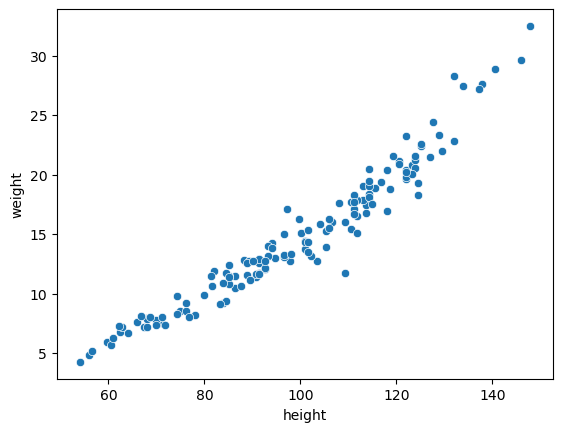

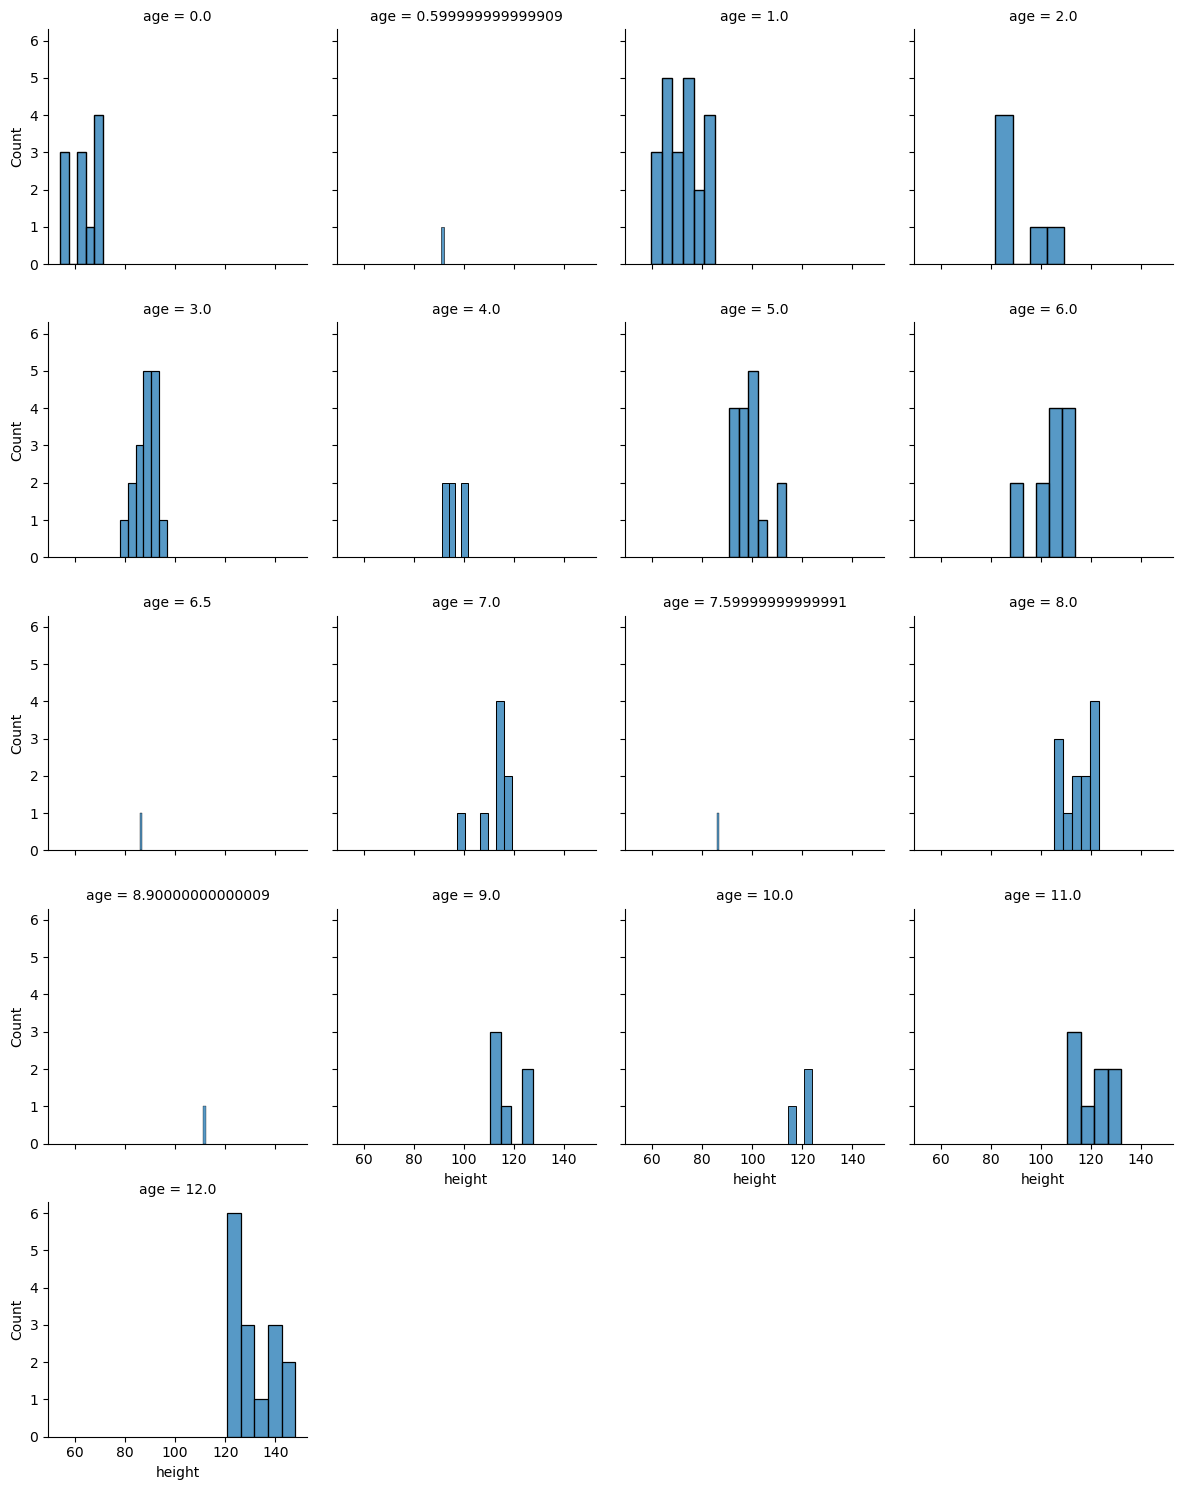

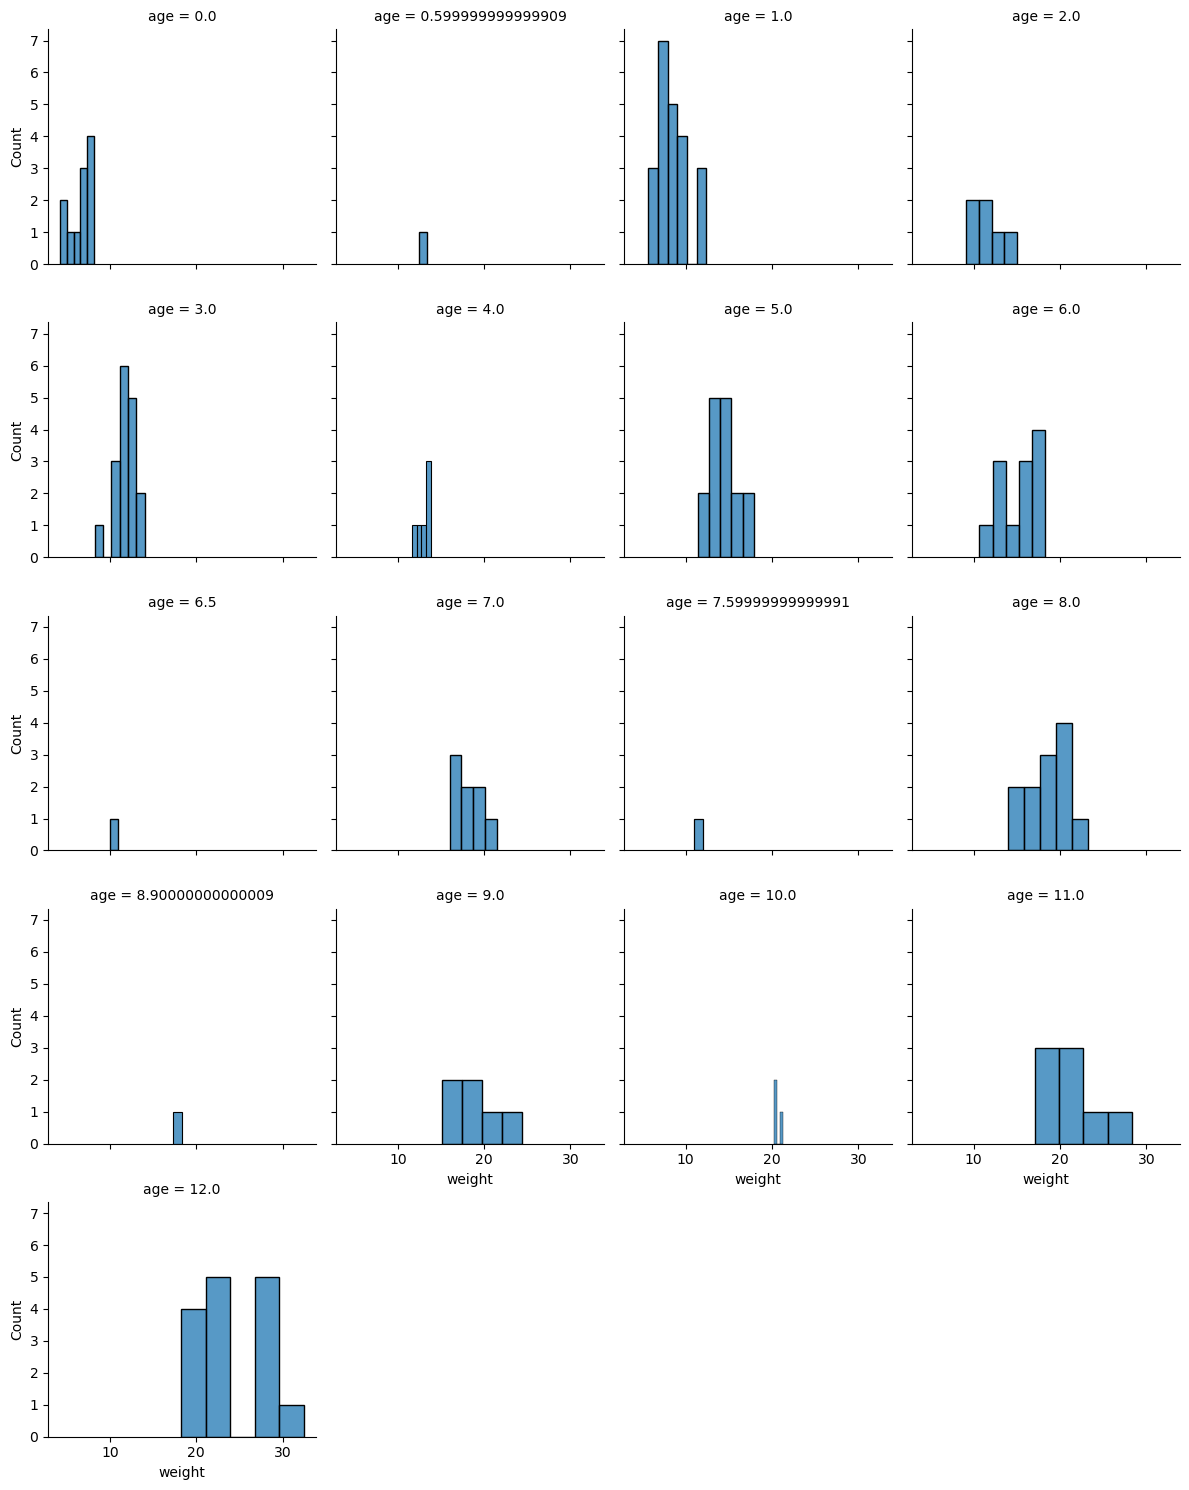

In [192]:
howell_data = pd.read_csv("../../datasets/Howell1.csv")
kids = howell_data[howell_data['age'] < 13]
sns.scatterplot(data=kids, x='height', y='weight')

g = sns.FacetGrid(kids, col="age", col_wrap=4)
g.map(sns.histplot, "height")
plt.show()
g = sns.FacetGrid(kids, col="age", col_wrap=4)
g.map(sns.histplot, "weight")
plt.show()


In [193]:
def simulate(age, params):
    rnd_gen = np.random.default_rng()
    mean_height = params['α_h'] + age * params['γ_a']    
    height = rnd_gen.normal(loc=mean_height, scale=(1 + age) * params['σ_h'])
    mean_weight = params['α_w'] + params['β_h'] * height + age * params['β_a']
    weight = rnd_gen.normal(loc=mean_weight, scale=params['σ_w'] * mean_weight)
    return (age, height, weight)

params = dict(
    α_h= 46, γ_a = 8, σ_h=0.5, β_h=0.02, α_w = 3, σ_w = 0.2,  β_a = 3
)

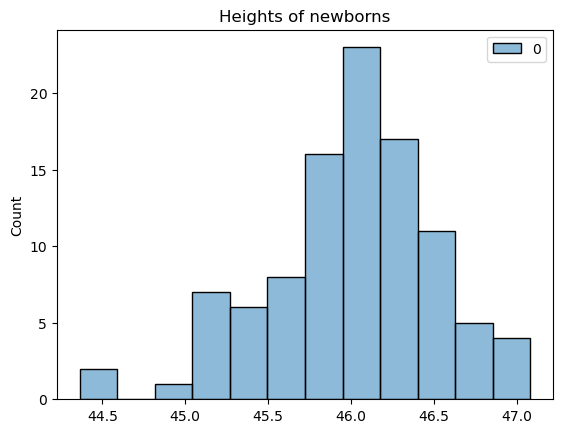

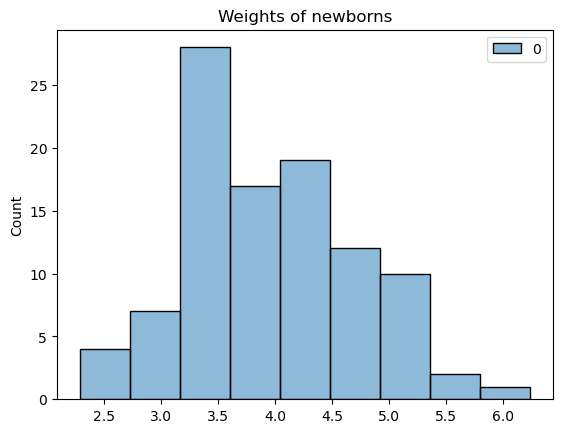

In [194]:
#try out with newborns


ages = np.zeros((100,1))
a,h,w = simulate(ages, params)

sns.histplot(h)
plt.title('Heights of newborns')
plt.show()

sns.histplot(w)
plt.title('Weights of newborns')
plt.show()

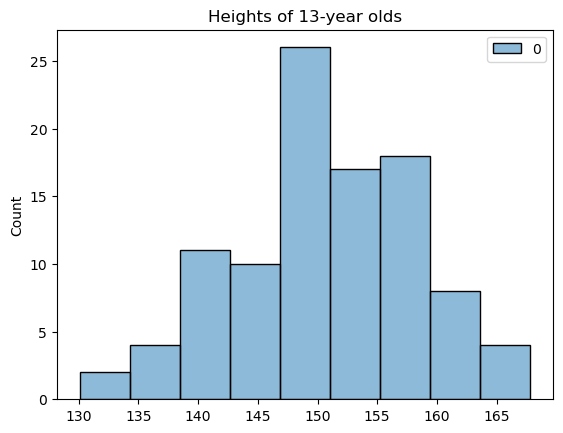

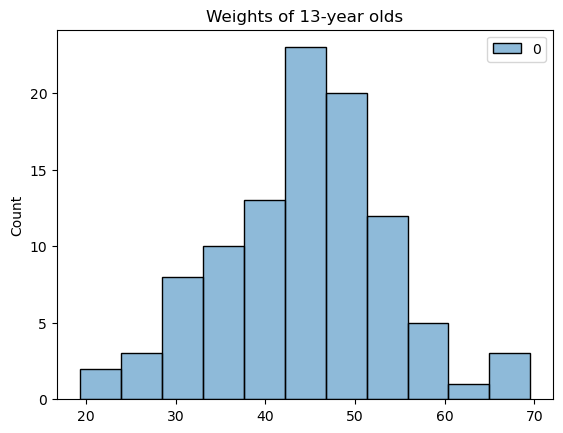

In [195]:
#try out with 13 year olds

ages = np.ones((100,1)) * 13
a,h,w = simulate(ages, params)

sns.histplot(h)
plt.title('Heights of 13-year olds')
plt.show()

sns.histplot(w)
plt.title('Weights of 13-year olds')
plt.show()

In [196]:
ages = np.random.default_rng().integers(low=0, high=14, size=1000)
a,h,w = simulate(ages, params)

simulated_kids = pd.DataFrame({"age": a, "height": h, "weight": w})

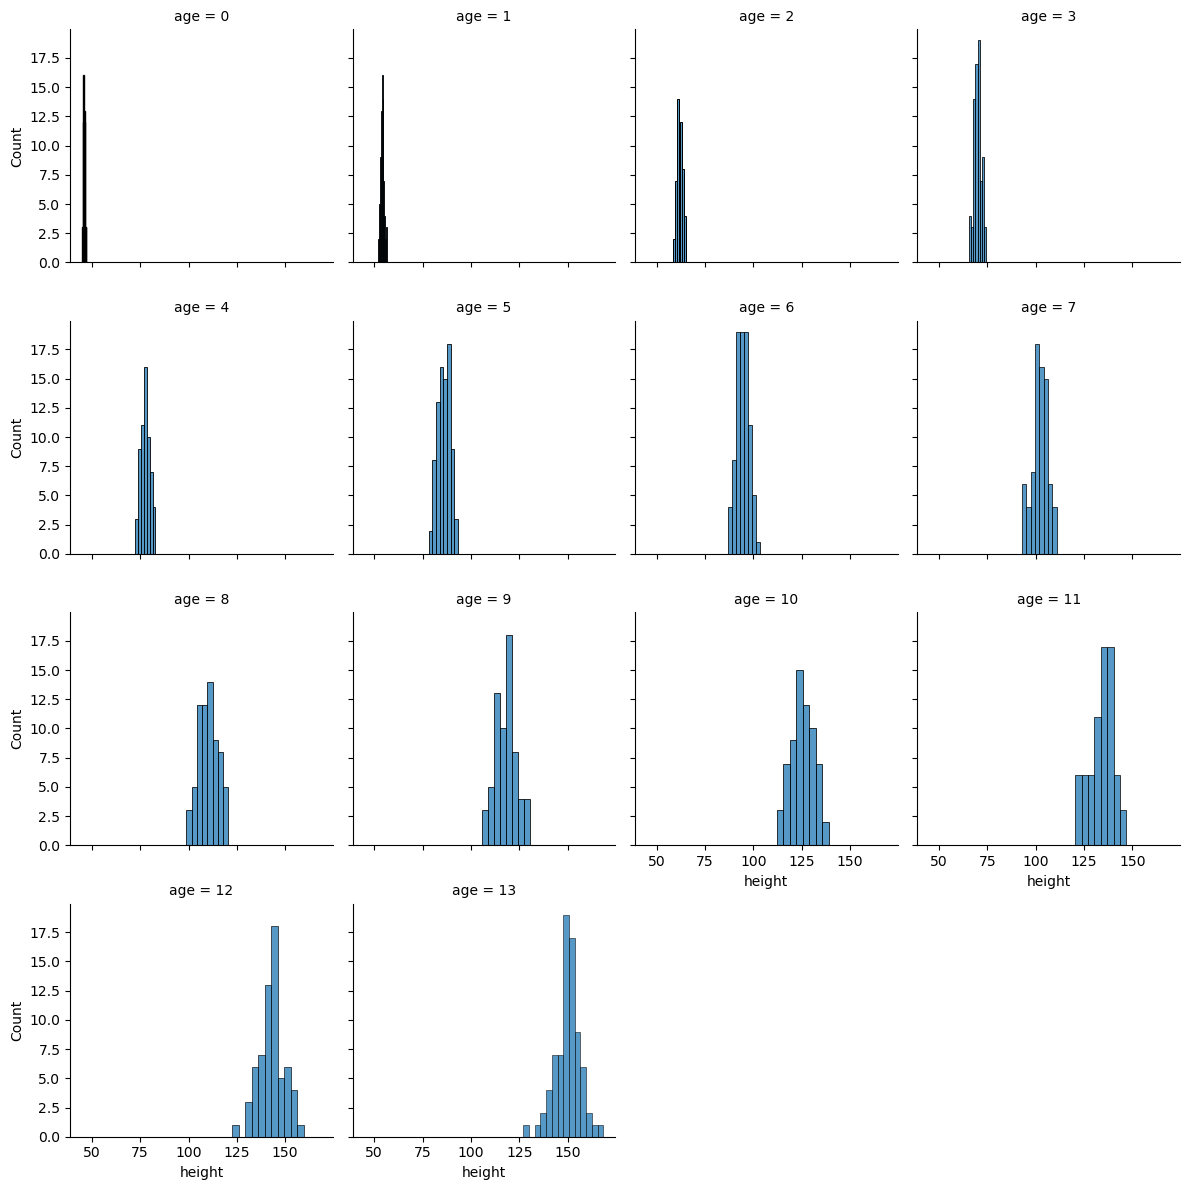

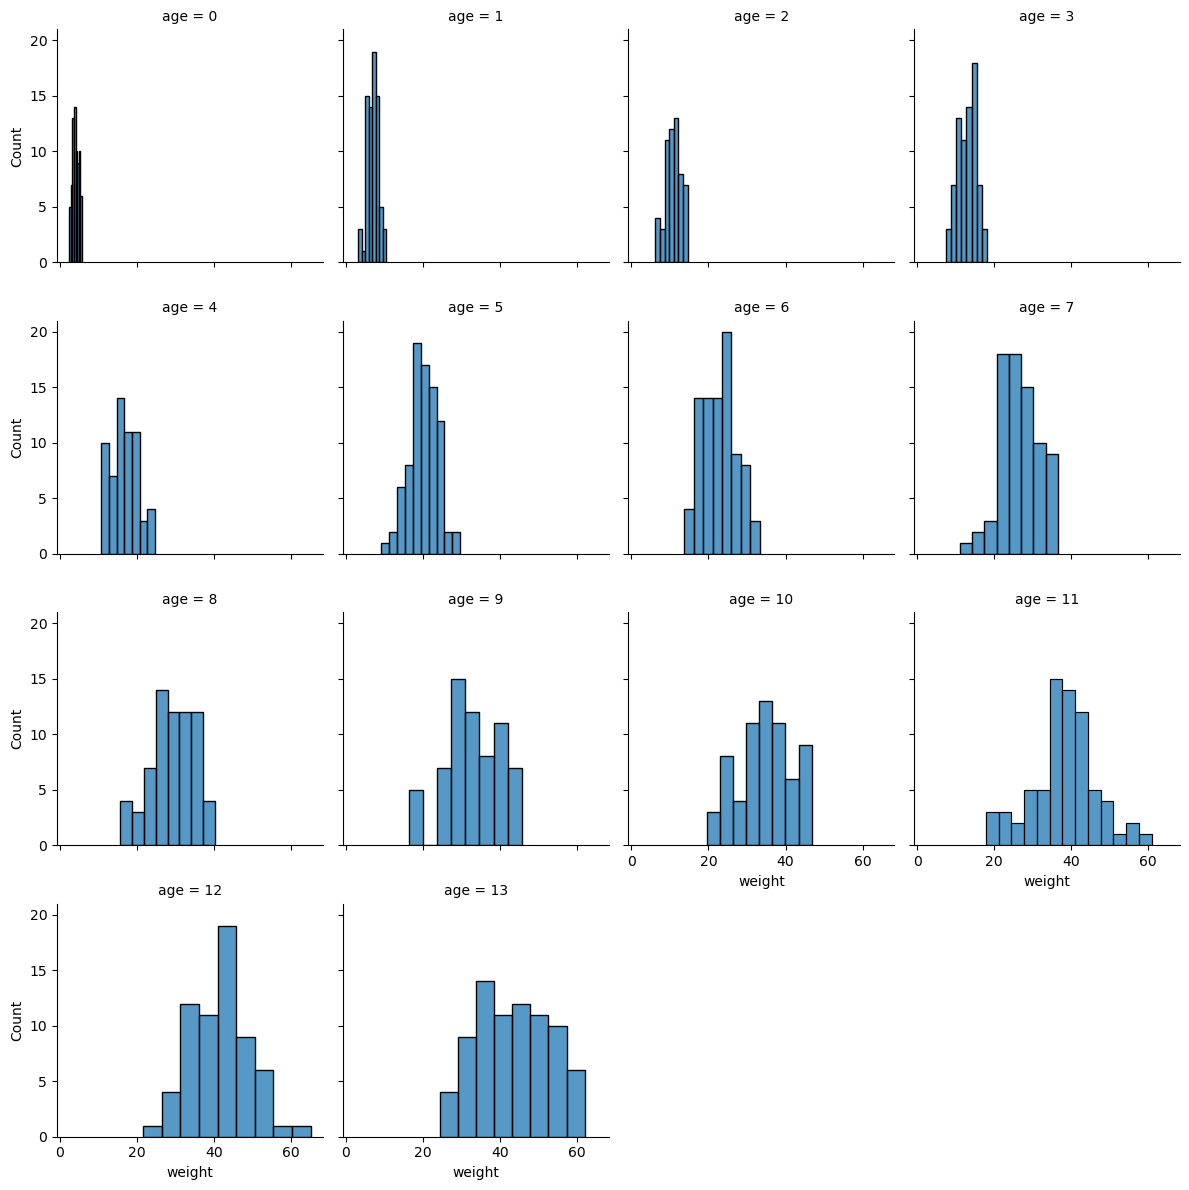

In [197]:
g = sns.FacetGrid(simulated_kids, col="age", col_wrap=4)
g.map(sns.histplot, "height")
plt.show()
g = sns.FacetGrid(simulated_kids, col="age", col_wrap=4)
g.map(sns.histplot, "weight")
plt.show()

<AxesSubplot: xlabel='height', ylabel='weight'>

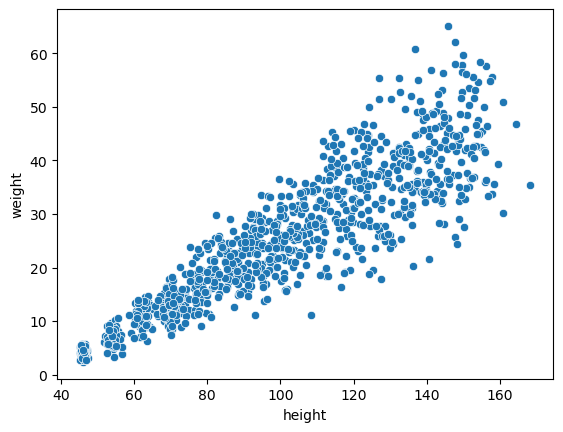

In [198]:
sns.scatterplot(data=simulated_kids, x='height', y='weight')

# Ex 2
Use a linear regression to estimate the total causal effect of each year of
growth on weight.

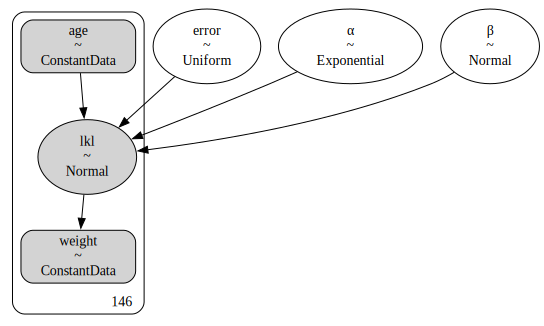

In [199]:
with pm.Model() as ex2_model:
    ages = pm.ConstantData("age", kids['age'].values)
    weights = pm.ConstantData("weight", kids['weight'].values)
    α = pm.Exponential("α", 2)
    β = pm.Normal("β", 0, 10)
    μ = α + pm.math.dot(β, ages)
    σ = pm.Uniform("error", 0, 10)
    lkl = pm.Normal("lkl", μ, σ, observed=weights)

pm.model_to_graphviz(ex2_model)

In [200]:
with ex2_model:
    ex2_trace = pm.sample()

az.summary(ex2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,1.377,0.057,1.264,1.477,0.001,0.001,1821.0,1803.0,1.0
α,7.168,0.382,6.482,7.931,0.009,0.006,1801.0,1692.0,1.0
error,2.571,0.153,2.279,2.846,0.003,0.002,2610.0,2598.0,1.0


In [201]:
with ex2_model:
    ex2_ppc = pm.sample_posterior_predictive(ex2_trace)

Sampling: [lkl]


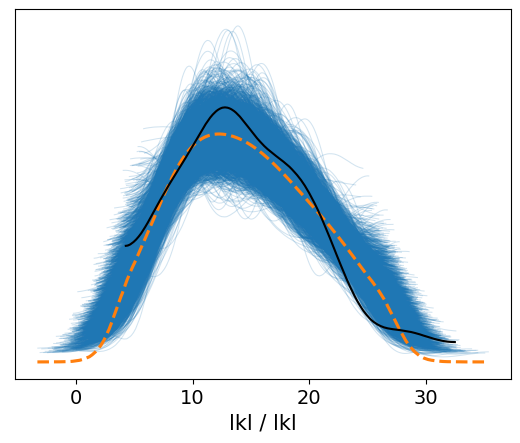

In [202]:
az.plot_ppc(ex2_ppc, legend=False)
plt.show()

# Ex3
Now suppose the causal association between age and weight might be different
for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior
contrasts as a summary.

In [203]:
kids.head()

,height,weight,age,male
18,121.92,19.617854,12.0,1
19,105.41,13.947954,8.0,0
20,86.36,10.489315,6.5,0
24,109.22,15.989118,7.0,0
30,114.30,17.860185,11.0,1


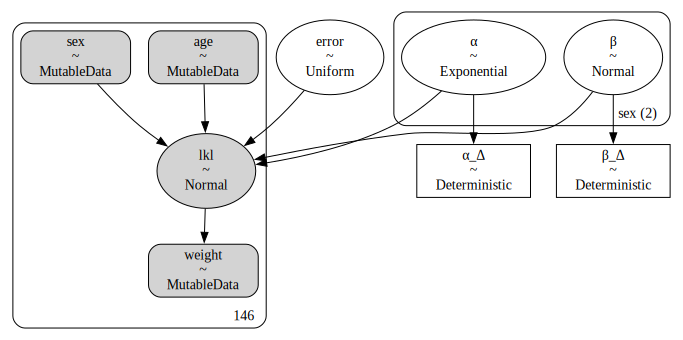

In [204]:
with pm.Model(coords={
    "sex": ["Female", "Male"]
}) as ex3_model:
    ages = pm.MutableData("age", kids['age'].values)
    weights = pm.MutableData("weight", kids['weight'].values)
    sexes = pm.MutableData("sex", kids['male'].values)
    α = pm.Exponential("α", 2, dims="sex")
    α_Δ = pm.Deterministic("α_Δ", α[1] - α[0])
    β = pm.Normal("β", 0, 10, dims='sex')
    β_Δ = pm.Deterministic("β_Δ", β[1] - β[0])
    μ = α[sexes] + β[sexes] * ages
    σ = pm.Uniform("error", 0, 10)
    lkl = pm.Normal("lkl", μ, σ, observed=weights)

pm.model_to_graphviz(ex3_model)

In [205]:
with ex3_model:
    ex3_trace = pm.sample()
    
az.summary(ex3_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[Female],1.352,0.076,1.213,1.499,0.001,0.001,2680.0,2500.0,1.0
β[Male],1.457,0.078,1.305,1.596,0.002,0.001,2690.0,2925.0,1.0
α[Female],6.558,0.509,5.597,7.520,0.010,0.007,2628.0,2270.0,1.0
α[Male],7.332,0.525,6.324,8.291,0.010,0.007,2756.0,2728.0,1.0
error,2.501,0.156,2.219,2.786,0.003,0.002,3048.0,2577.0,1.0
α_Δ,0.775,0.728,-0.637,2.104,0.014,0.010,2733.0,2726.0,1.0
β_Δ,0.105,0.108,-0.106,0.297,0.002,0.002,2626.0,2829.0,1.0


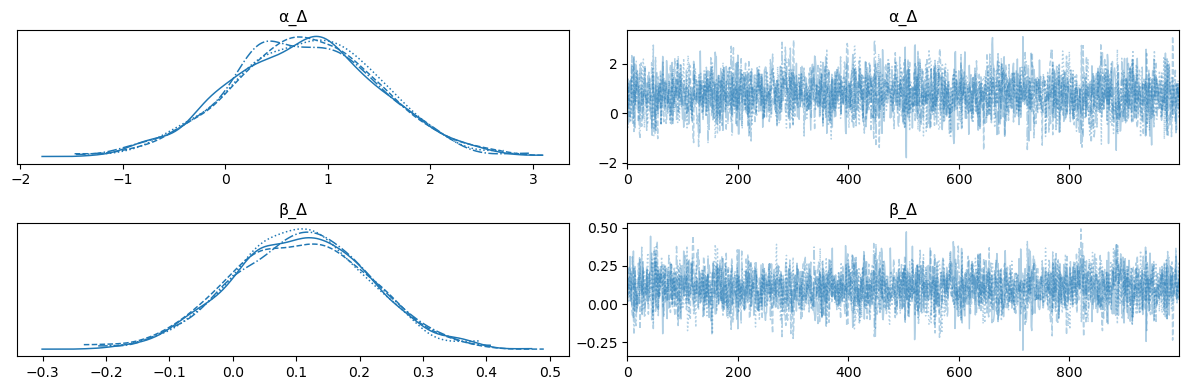

In [206]:
az.plot_trace(ex3_trace, var_names=["α_Δ", "β_Δ"])
plt.tight_layout()

In [207]:
with ex3_model:
    pm.set_data({"sex": np.zeros((len(kids['age']),), dtype=np.int32), "age": kids['age']})
    ex3_ppc_female = pm.sample_posterior_predictive(ex3_trace)
    pm.set_data({"sex": np.ones((len(kids['age']),), dtype=np.int32), "age": kids['age']})
    ex3_ppc_male = pm.sample_posterior_predictive(ex3_trace)

Sampling: [lkl]


Sampling: [lkl]


In [224]:
ex3_ppc_male['posterior_predictive']['lkl'][0][1]

<xarray.DataArray 'lkl' (lkl_dim_2: 146)>
array([21.44888948, 19.9152718 , 17.12532755, 17.04528653, 24.05177475,
       16.37001269, 23.11704199, 17.35540277, 20.97140156, 14.28677235,
       19.35827223,  6.37147856, 28.65859659, 15.52501089, 17.10800529,
       13.8373012 , 25.67564501, 20.85947268, 15.89518064, 25.96881865,
       21.48187923, 16.80536998,  7.92827574, 14.21985575, 19.77488442,
       13.46449422, 10.49486592, 24.51981245, 21.05665322, 15.45673899,
       25.12876878, 19.36520214,  9.83066667, 23.01353984, 12.36603346,
       10.62376526, 17.47779944, 14.82973444, 14.07511943, 14.44854841,
       13.50389511,  9.91800317, 12.13259623, 13.72945569, 14.16654779,
       18.1256811 , 23.00237812, 19.76567645, 26.73798276, 20.09250151,
       15.96780893, 15.54883963, 23.36380338, 22.33027304, 16.03559953,
       15.11025838, 17.49647513, 12.68696999,  8.09352119,  9.18796536,
        8.73363602, 15.78306604, 13.77275463, 16.05448128, 10.25419789,
       10.48274316,  5.4214321 , 12.43882527, 25.28716171,  8.9493634 ,
       19.7102835 , 10.74890246, 15.77769421, 11.87497618, 14.92861512,
        6.0784329 ,  5.43275601, 17.38847827,  9.76933874,  9.91725775,
       12.00811499,  8.3689496 ,  9.1226276 , 12.73387959, 12.49510394,
       11.23941882,  8.37842819, 27.05705534,  7.97633332, 11.92914676,
       10.10480553, 13.88386669, 15.23895909, 13.16756041, 21.53061661,
       13.88939894, 20.63871439, 13.82677743, 11.53196704, 15.1537949 ,
        8.21965292, 19.46416225,  7.31132253, 11.16305616,  5.17935596,
       22.33396658, 12.03895759, 23.05395633, 17.66066317, 13.99105728,
       11.1134113 , 19.32509302, 13.56256428,  6.53819421,  6.13956897,
       22.71292681, 11.11736212,  4.88147709, 13.6498479 , 19.86261052,
       12.1954609 , 22.70150889, 13.79045777,  9.69568   , 11.84917035,
       21.44757957, 15.74285911, 15.51153991, 23.13554166, 13.62205887,
       15.77009667, 24.44077118,  9.30282202, 15.88930278,  6.13487786,
        8.72351388, 15.88165244, 18.88023273, 14.90383735, 27.93847146,
       14.75362111, 14.51927518, 18.63090941,  8.28105158,  9.36885509,
       10.35748581])
Coordinates:
    chain      int64 0
    draw       int64 1
  * lkl_dim_2  (lkl_dim_2) int64 0 1 2 3 4 5 6 7 ... 139 140 141 142 143 144 145

In [225]:
ex3_ppc_male['posterior_predictive']['lkl'][0][0:2].to_numpy().flatten()[146:]

array([21.44888948, 19.9152718 , 17.12532755, 17.04528653, 24.05177475,
       16.37001269, 23.11704199, 17.35540277, 20.97140156, 14.28677235,
       19.35827223,  6.37147856, 28.65859659, 15.52501089, 17.10800529,
       13.8373012 , 25.67564501, 20.85947268, 15.89518064, 25.96881865,
       21.48187923, 16.80536998,  7.92827574, 14.21985575, 19.77488442,
       13.46449422, 10.49486592, 24.51981245, 21.05665322, 15.45673899,
       25.12876878, 19.36520214,  9.83066667, 23.01353984, 12.36603346,
       10.62376526, 17.47779944, 14.82973444, 14.07511943, 14.44854841,
       13.50389511,  9.91800317, 12.13259623, 13.72945569, 14.16654779,
       18.1256811 , 23.00237812, 19.76567645, 26.73798276, 20.09250151,
       15.96780893, 15.54883963, 23.36380338, 22.33027304, 16.03559953,
       15.11025838, 17.49647513, 12.68696999,  8.09352119,  9.18796536,
        8.73363602, 15.78306604, 13.77275463, 16.05448128, 10.25419789,
       10.48274316,  5.4214321 , 12.43882527, 25.28716171,  8.94

In [238]:
weight_diffs = (
    ex3_ppc_male['posterior_predictive']['lkl'].to_numpy().flatten('F') - 
    ex3_ppc_female['posterior_predictive']['lkl'].to_numpy().flatten('F')
)

ages = np.concatenate([
    ex3_ppc_male['constant_data']['age'].to_numpy().flatten(),    
])

In [233]:
ex3_ppc_male['posterior_predictive']['lkl'].to_numpy().flatten().std()

6.102577133718172

In [239]:
diffs = pd.DataFrame({'age': np.repeat(ages, 4000), 'diffs': weight_diffs})
summaries = diffs.groupby('age').agg(['mean', 'std'])
summaries.columns = summaries.columns.to_flat_index()
summaries.columns = ['mean', 'sd']
summaries = summaries.reset_index()
summaries['lower'] = summaries['mean'] -  summaries['sd']
summaries['upper'] = summaries['mean'] +  summaries['sd']
summaries

,age,mean,sd,lower,upper
0,0.0,0.785081,3.629163,-2.844082,4.414243
1,0.6,0.797190,3.597152,-2.799962,4.394342
2,1.0,0.869201,3.609940,-2.740739,4.479141
3,2.0,0.971901,3.611967,-2.640066,4.583868
4,3.0,1.105561,3.565400,-2.459839,4.670961
5,4.0,1.209765,3.590809,-2.381044,4.800573
6,5.0,1.323117,3.568407,-2.245290,4.891524
7,6.0,1.388968,3.585322,-2.196354,4.974289
8,6.5,1.439827,3.560571,-2.120744,5.000398
9,7.0,1.509737,3.594054,-2.084316,5.103791


In [240]:
line = alt.Chart(summaries).mark_line().encode(
    x="age",
    y=alt.Y('mean', scale=alt.Scale(domain=(-10, 10)))
)

band = alt.Chart(summaries).mark_errorband().encode(
    x='age',
    y='lower',
    y2='upper'
)

line+band

/home/aurimas/micromamba/envs/rethinking/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)